<a href="https://colab.research.google.com/github/Nouman-wisal/pytorch/blob/main/02_pytorch_Neural_Network_classification_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# `1.`Neural Network Classification model
classification is predicting whether something is one thing or another(there can be multiple things as options)

#  Make classification data and get it ready

In [ ]:
import torch
from torch import nn
import matplotlib.pyplot as plt
import pandas as pd


from sklearn.datasets import make_circles

X ,y =make_circles(n_samples=1000, noise=0.03, random_state=42)
print(X[:5])
print(y[:5],"\n")

len(X),X.shape , len(y),y.shape


[[ 0.75424625  0.23148074]
 [-0.75615888  0.15325888]
 [-0.81539193  0.17328203]
 [-0.39373073  0.69288277]
 [ 0.44220765 -0.89672343]]
[1 1 1 1 0] 



(1000, (1000, 2), 1000, (1000,))

In [ ]:


# convert it to data frame
df=pd.DataFrame({
    'X1': X[:,0],
    'X2': X[:,1],
    'label':y
})

print(df.head(5))
df["label"].value_counts() # meaning out 1000 features 500 has label=0 and 500 has label=1,they both have different colors

         X1        X2  label
0  0.754246  0.231481      1
1 -0.756159  0.153259      1
2 -0.815392  0.173282      1
3 -0.393731  0.692883      1
4  0.442208 -0.896723      0


,count
label,
1,500
0,500


#Visualizing the data through plotting
##Plotting the make circle toy data

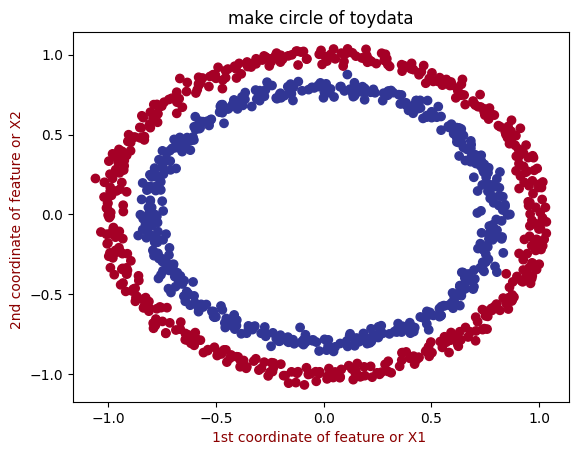

In [ ]:


plt.scatter(X[:,0], X[:,1], c=y , cmap=plt.cm.RdYlBu)
plt.xlabel("1st coordinate of feature or X1 ",c="#8B0000")
plt.ylabel("2nd coordinate of feature or X2 ",c="#8B0000")
plt.title("make circle of toydata")

plt.show()


#Toy data comes in numpy format
###converting it to tensors before splitting for trainig and testing

In [ ]:

print(type(X), X.dtype, type(y), y.dtype,"\n")

# converting X, y to tensors and changing dtype
X=torch.from_numpy(X).type(torch.float32)
y=torch.from_numpy(y).type(torch.float)

print(type(X), X.dtype, type(y), y.dtype)

<class 'numpy.ndarray'> float64 <class 'numpy.ndarray'> int64 

<class 'torch.Tensor'> torch.float32 <class 'torch.Tensor'> torch.float32


#Splitting data for Trainig and Testing

In [ ]:
from sklearn.model_selection import train_test_split

x_train , x_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

len(x_train), len(x_test), len(y_train), len(y_test), x_train.shape

(800, 200, 800, 200, torch.Size([800, 2]))

#Building a Model for binary classification


1.   setup device agnostic code
1.   build model subclass from nn.Module
2.   setup loss and optimizer
2.   train and test model



In [ ]:
device= 'cuda' if torch.cuda.is_available else 'cpu'
device , torch.__version__

('cuda', '2.6.0+cu124')

In [ ]:
"""A simple neural network model for binary classification of circular data."""
class CircleModelV0(nn.Module):
  def __init__(self):
    super().__init__()

    """Initializes the model with two linear layers."""
    self.layer1 = nn.Linear(in_features=2, out_features=5)  # 1 hidden layer with 5 neurons
    self.layer2 = nn.Linear(in_features=5, out_features=1)  # the Output layer for binary classification


  def forward(self, x:torch.Tensor) -> torch.Tensor:
    """
    Performs a forward pass through the model.

    Args:
        x: The input tensor.

    Returns:
        The output tensor after passing through the linear layers.
    """
    return self.layer2(self.layer1(x))


In [ ]:
model_0= CircleModelV0().to(device)
model_0
# model_0.state_dict()


CircleModelV0(
  (layer1): Linear(in_features=2, out_features=5, bias=True)
  (layer2): Linear(in_features=5, out_features=1, bias=True)
)

#The othe way to create this model.
this is for only simple models like ours

In [ ]:
model_0= nn.Sequential(
    nn.Linear(in_features=2, out_features=5),
    nn.Linear(in_features=5, out_features=1)
).to(device)

model_0
# model_0.state_dict()

Sequential(
  (0): Linear(in_features=2, out_features=5, bias=True)
  (1): Linear(in_features=5, out_features=1, bias=True)
)

#Setting up Loss_fn & Optimizer & Accuracy Calculator

In [ ]:
# Setting up the loss function & Optimizer & Accuracy Calculator
# lossfn = BCELoss() requires the input to have already gone through activation function prior to input to BECLoss()

loss_fn = nn.BCEWithLogitsLoss() # comes with BUilt_in sigmoid activation function and better more stable numerically --> recommened

optimizer= torch.optim.Adam(params=model_0.parameters(),
                            lr= 0.1)

def accuracy_fn(y_true, y_pred):
  correct= torch.eq(y_true, y_pred).sum().item()
  acc= (correct / len(y_pred)) *100
  return acc

###Fyi test: our model outputs ***raw logits*** as preds, we have to turn them to ***prediction probabilities*** and then to ***prediction labels***

*   from **Raw Logits**  --->  **prediction probabilities`through sigmoid activation func`**  --->  **prediction labels(y_preds)`by rounding`**




In [ ]:
# this is just fyi to be ussed after trainig

model_0.eval()

with torch.inference_mode():
  y_logits= model_0(x_test.to(device))

y_predss= torch.round(torch.sigmoid(y_logits))
# y_predss.squeeze()

print(y_predss[:5],"\n")
                              #OR

  # In full 1 step (logits -> pred probs -> pred labels)
with torch.inference_mode():
  y_predss_1= torch.round(torch.sigmoid(model_0(x_test.to(device))))

print(y_predss_1[:5],"\n")

# comparing &check which of them are equal to each other
print(torch.eq(y_predss, y_predss_1)[:5].squeeze())


tensor([[0.],
        [0.],
        [1.],
        [0.],
        [1.]], device='cuda:0') 

tensor([[0.],
        [0.],
        [1.],
        [0.],
        [1.]], device='cuda:0') 

tensor([True, True, True, True, True], device='cuda:0')


#Trainig and Testing the Model

In [ ]:
# converting data to device
x_train, y_train = x_train.to(device), y_train.to(device)
x_test, y_test = x_test.to(device), y_test.to(device)

torch.manual_seed(42)
torch.cuda.manual_seed(42)

epoch=100

for epoch in range(epoch):
  model_0.train()

# the forward pass
  train_logits= model_0(x_train).squeeze()                    # the ypred after forward loss but it's in raw logits and must be converted to y_pred

  train_preds= torch.round(torch.sigmoid(train_logits))         # the y_preds

  # claculate the loss / accuracy
  train_loss= loss_fn(train_logits, y_train)

  train_accuracy= accuracy_fn(y_true=y_train, y_pred=train_preds)

  # zero grad
  optimizer.zero_grad()

  # back propagation
  train_loss.backward()

  # gradient descent
  optimizer.step()

                        # Now Testing the Model

  model_0.eval()

  with torch.inference_mode():
    # the forward pass
    test_logits= model_0(x_test).squeeze()

    test_preds= torch.round(torch.sigmoid(test_logits))

  # calculate the loss / accuracy
  test_loss= loss_fn(test_logits, y_test)

  test_accuracy= accuracy_fn(y_true=y_test, y_pred= test_preds)

  if epoch % 10 ==0:
    print(f'epoch:{epoch}, training loss: {train_loss:.5f}, training accuracy: {train_accuracy:.2f}%, test loss: {test_loss:.5f}, testing accuracy: {test_accuracy:.2f}%')


epoch:0, training loss: 0.72940, training accuracy: 51.62%, test loss: 0.69390, testing accuracy: 52.00%
epoch:10, training loss: 0.69352, training accuracy: 52.75%, test loss: 0.69409, testing accuracy: 50.00%
epoch:20, training loss: 0.69357, training accuracy: 54.00%, test loss: 0.69584, testing accuracy: 48.00%
epoch:30, training loss: 0.69314, training accuracy: 53.75%, test loss: 0.69421, testing accuracy: 48.00%
epoch:40, training loss: 0.69303, training accuracy: 51.75%, test loss: 0.69490, testing accuracy: 46.50%
epoch:50, training loss: 0.69299, training accuracy: 51.25%, test loss: 0.69467, testing accuracy: 47.50%
epoch:60, training loss: 0.69299, training accuracy: 51.00%, test loss: 0.69456, testing accuracy: 46.00%
epoch:70, training loss: 0.69298, training accuracy: 51.38%, test loss: 0.69477, testing accuracy: 46.00%
epoch:80, training loss: 0.69298, training accuracy: 51.25%, test loss: 0.69460, testing accuracy: 45.50%
epoch:90, training loss: 0.69298, training accu

# Make predictions and evaluate the model
From the metrics it looks like our model isn't learning anything...

So to inspect it let's make some predictions and make them visual!

In other words, "Visualize, visualize, visualize!"

To do so, we're going to import a function called plot_decision_boundary() - https://github.com/mrdbourke/pytorch-deep-learning/blob/main/helper_functions.py

In [ ]:
import requests
from pathlib import Path

if Path('helper_function.py').is_file():
  print('helper function file already exists,skipping download')

else:
  print('downloading content into helper functoin file')
  request= requests.get('https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/refs/heads/main/helper_functions.py')

  # folder=Path('HelperFunctions').mkdir(parents=True, exist_ok=True)

  with open('helper_function.py','wb') as f:
    f.write(request.content)

from helper_function import plot_predictions, plot_decision_boundary


downloading content into helper functoin file


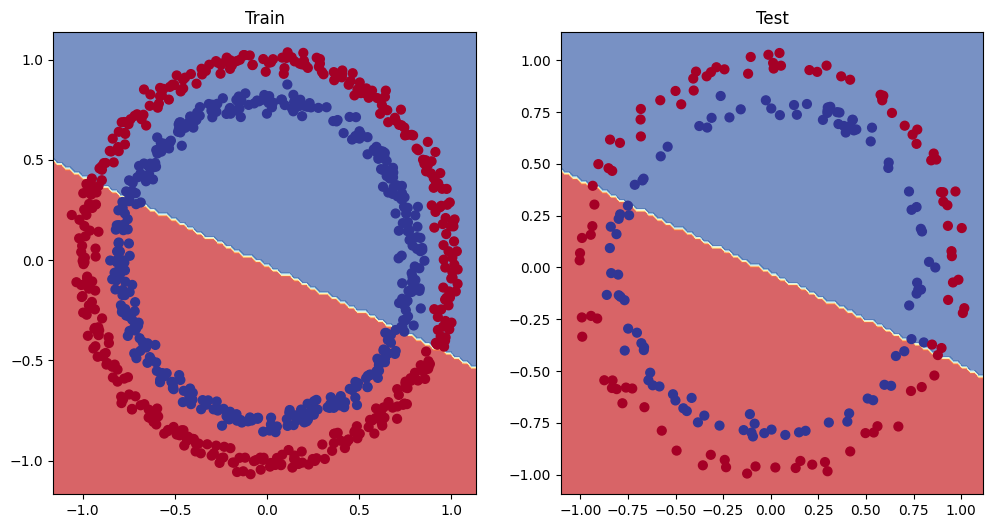

In [ ]:


plt.figure(figsize=(12,6))
plt.subplot(1,2,1)
plt.title('Train')
plot_decision_boundary(model_0, x_train, y_train)

plt.subplot(1,2,2)
plt.title('Test')
plot_decision_boundary(model_0, x_test, y_test)



#Adjusting the model

# Improving a model (from a model perspective)
Add more layers - give the model more chances to learn about patterns in the data
Add more hidden units - go from 5 hidden units to 10 hidden units
Fit for longer
Changing the activation functions
Change the learning rate
Change the loss function
These options are all from a model's perspective because they deal directly with the model, rather than the data.

And because these options are all values we (as machine learning engineers and data scientists) can change, they are referred as hyperparameters.

Let's try and improve our model by:

Adding more hidden units: 5 -> 10
Increase the number of layers: 2 -> 3
Increase the number of epochs: 100 -> 1000

In [ ]:
class CircleModelV1(nn.Module):
  def __init__(self):
    super().__init__()

    self.layer1= nn.Linear(in_features=2, out_features=10)
    self.layer2= nn.Linear(in_features=10, out_features=10)
    self.layer3= nn.Linear(in_features=10, out_features=1)

  def forward(self, x:torch.Tensor) ->torch.Tensor:
    # z=self.layer1(x)
    # z1=self.layer2(z)
    # z2=self.layer3(z1)
    # return z2
    return self.layer3(self.layer2(self.layer1(x))) # --> recommended

model_1= CircleModelV1().to(device)

model_1, next(model_1.parameters()).device, model_1.state_dict()


(CircleModelV1(
   (layer1): Linear(in_features=2, out_features=10, bias=True)
   (layer2): Linear(in_features=10, out_features=10, bias=True)
   (layer3): Linear(in_features=10, out_features=1, bias=True)
 ),
 device(type='cuda', index=0),
 OrderedDict([('layer1.weight',
               tensor([[ 0.5406,  0.5869],
                       [-0.1657,  0.6496],
                       [-0.1549,  0.1427],
                       [-0.3443,  0.4153],
                       [ 0.6233, -0.5188],
                       [ 0.6146,  0.1323],
                       [ 0.5224,  0.0958],
                       [ 0.3410, -0.0998],
                       [ 0.5451,  0.1045],
                       [-0.3301,  0.1802]], device='cuda:0')),
              ('layer1.bias',
               tensor([-0.3258, -0.0829, -0.2872,  0.4691, -0.5582, -0.3260, -0.1997, -0.4252,
                        0.0667, -0.6984], device='cuda:0')),
              ('layer2.weight',
               tensor([[ 0.2856, -0.2686,  0.2441,  0.0526,

In [ ]:
# loss function / accuracy function and optimizer

loss_fn= nn.BCEWithLogitsLoss()

optimizer= torch.optim.Adam(params=model_1.parameters(),
                            lr=0.1)

def accuracy_fn(y_true, y_pred):
  correct= torch.eq(y_true, y_pred).sum().item()
  acc=(correct/len(y_pred))*100
  return acc

In [ ]:
# training and testind the model

torch.manual_seed(42)
torch.cuda.manual_seed(42)

x_train, y_train =  x_train.to(device), y_train.to(device)
x_test, y_test =    x_test.to(device),  y_test.to(device)

epoch= 1000

for epoch in range(epoch):
  model_1.train()

  train_logits= model_1(x_train).squeeze()
  train_pred= torch.round(torch.sigmoid(train_logits))

  train_loss= loss_fn(train_logits, y_train)
  train_accuracy= accuracy_fn(y_true= y_train, y_pred= train_pred)

  optimizer.zero_grad()

  train_loss.backward()

  optimizer.step()

  #                           Training done now Testing/Evaluating model

  model_1.eval()

  with torch.inference_mode():
    test_logits= model_1(x_test).squeeze()
    test_preds= torch.round(torch.sigmoid(test_logits))

    test_loss= loss_fn(test_logits, y_test)
    test_accuracy= accuracy_fn(y_true=y_test, y_pred= test_preds)

  # now some printing
  if epoch % 50 == 0:
    print(f'epoch:{epoch}, train_loss:{train_loss:.5f}, trian_accuracy:{train_accuracy:.2f}% ::: test_loss:{test_loss:.5f}, test_accuracy:{test_accuracy:.2f}%')

epoch:0, train_loss:0.69396, trian_accuracy:50.88% ::: test_loss:0.79303, test_accuracy:50.00%
epoch:50, train_loss:0.69299, trian_accuracy:51.50% ::: test_loss:0.69490, test_accuracy:45.50%
epoch:100, train_loss:0.69298, trian_accuracy:51.50% ::: test_loss:0.69470, test_accuracy:45.50%
epoch:150, train_loss:0.69298, trian_accuracy:51.12% ::: test_loss:0.69468, test_accuracy:46.00%
epoch:200, train_loss:0.69317, trian_accuracy:48.62% ::: test_loss:0.69504, test_accuracy:47.00%
epoch:250, train_loss:0.69298, trian_accuracy:51.25% ::: test_loss:0.69469, test_accuracy:45.00%
epoch:300, train_loss:0.69298, trian_accuracy:51.12% ::: test_loss:0.69468, test_accuracy:46.00%
epoch:350, train_loss:0.69298, trian_accuracy:51.00% ::: test_loss:0.69468, test_accuracy:46.00%
epoch:400, train_loss:0.69298, trian_accuracy:51.00% ::: test_loss:0.69468, test_accuracy:46.00%
epoch:450, train_loss:0.69298, trian_accuracy:51.00% ::: test_loss:0.69468, test_accuracy:46.00%
epoch:500, train_loss:0.69298, tr

In [ ]:
# importing helper functions to visualize

import requests
from pathlib import Path

if Path('helper_functions1.py').is_file():
  print('helper_function1 file alreay exists, skipping download')
else:
  print('downloading helper_function1 file')
  request= requests.get('https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/helper_functions.py')

  with open('helper_function1.py','wb') as f:
    f.write(request.content)

from helper_function1 import plot_predictions, plot_decision_boundary

downloading helper_function1 file


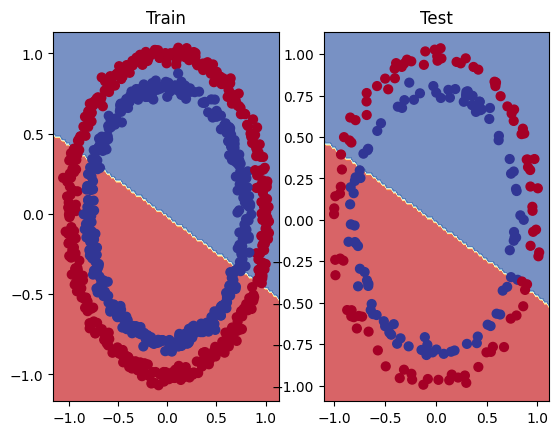

In [ ]:
# plt.figure(figsize=(12,6))
plt.subplot(1,2,1)
plt.title('Train')
plot_decision_boundary(model_1, x_train, y_train)

plt.subplot(1,2,2)
plt.title('Test')
plot_decision_boundary(model_1, x_test, y_test)


##Fitting regression data on this model to check if someting is wrong or not in model acrhitecture

In [ ]:
weight= 0.7
bias=0.3

start=0
end=1
step=0.01

x_regression= torch.arange(start, end, step).unsqueeze(dim=1)
y_regression= weight * x_regression + bias

print(x_regression[:5],'\n\n',y_regression[:5])


tensor([[0.0000],
        [0.0100],
        [0.0200],
        [0.0300],
        [0.0400]]) 

 tensor([[0.3000],
        [0.3070],
        [0.3140],
        [0.3210],
        [0.3280]])


80 20 80 20 



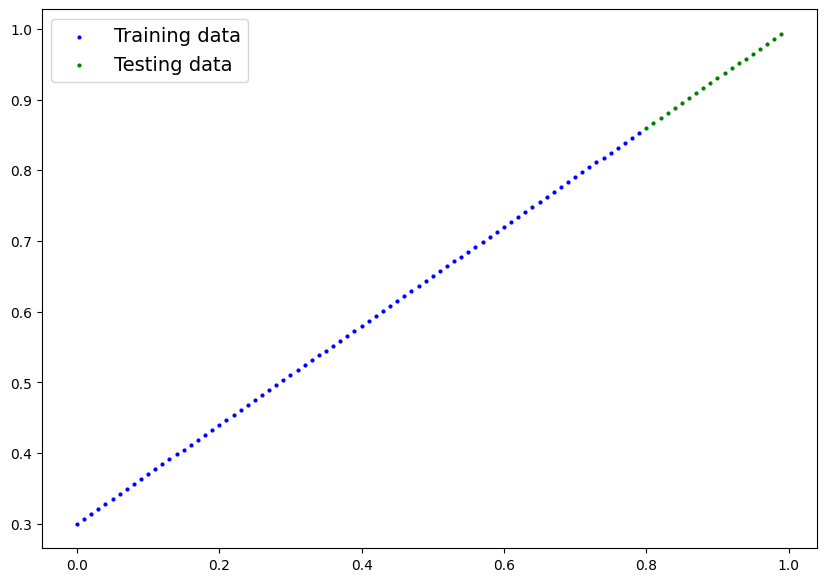

In [ ]:
# train_test_split
train_split= int(0.8 *len(x_regression))

x_train_reg, x_test_reg= x_regression[:train_split], x_regression[train_split:]
y_train_reg, y_test_reg= y_regression[:train_split], y_regression[train_split:]

print(len(x_train_reg), len(x_test_reg), len(y_train_reg), len(y_test_reg),"\n")

from helper_function1 import plot_predictions, plot_decision_boundary

# sattering the data on graph to visualize

plot_predictions(train_data= x_train_reg,
                 train_labels= y_train_reg,
                 test_data= x_test_reg,
                 test_labels=y_test_reg,
                 predictions=None)

In [ ]:
model_1, x_train_reg[:5], y_test_reg[:5]

(CircleModelV1(
   (layer1): Linear(in_features=2, out_features=10, bias=True)
   (layer2): Linear(in_features=10, out_features=10, bias=True)
   (layer3): Linear(in_features=10, out_features=1, bias=True)
 ),
 tensor([[0.0000],
         [0.0100],
         [0.0200],
         [0.0300],
         [0.0400]]),
 tensor([[0.8600],
         [0.8670],
         [0.8740],
         [0.8810],
         [0.8880]]))

## let's check if our `classification` model works by trainig it on this data, to see if it's capable of learning

In [ ]:
# i'm gonna make it in sequential way

model_2= nn.Sequential(
    nn.Linear(1, 10),
    nn.Linear(10, 10),
    nn.Linear(10, 1)
).to(device)

model_2, next(model_2.parameters()).device

(Sequential(
   (0): Linear(in_features=1, out_features=10, bias=True)
   (1): Linear(in_features=10, out_features=10, bias=True)
   (2): Linear(in_features=10, out_features=1, bias=True)
 ),
 device(type='cuda', index=0))

In [ ]:
# loss and optimizer functions

loss_fn= nn.L1Loss()
optimizer= torch.optim.Adam(params= model_2.parameters(),
                           lr=0.01)

In [ ]:
# training and evaluating the model on this data

torch.manual_seed(42)
torch.cuda.manual_seed(42)

x_train_reg, y_train_reg= x_train_reg.to(device), y_train_reg.to(device)
x_test_reg, y_test_reg= x_test_reg.to(device), y_test_reg.to(device)

epoch= 1000

for epoch in range(epoch):
  model_2.train()

  train_preds_reg= model_2(x_train_reg)

  train_loss_reg= loss_fn(train_preds_reg, y_train_reg)

  optimizer.zero_grad()
  train_loss_reg.backward()
  optimizer.step()

  #             evalauting/testing model

  model_2.eval()

  with torch.inference_mode():
    test_pred_reg= model_2(x_test_reg)
    test_loss_reg=loss_fn(test_pred_reg, y_test_reg)

  if epoch % 100 ==0:
    print(f'epoch:{epoch}, train_loss:{train_loss_reg}, test_loss:{test_loss_reg}')



epoch:0, train_loss:0.7598585486412048, test_loss:0.7761995792388916
epoch:100, train_loss:0.0033510648645460606, test_loss:0.0019438446033746004
epoch:200, train_loss:0.004583177622407675, test_loss:0.012323135510087013
epoch:300, train_loss:0.0019620582461357117, test_loss:0.01618785224854946
epoch:400, train_loss:0.010173458606004715, test_loss:0.02107691764831543
epoch:500, train_loss:0.008030595257878304, test_loss:0.011629429645836353
epoch:600, train_loss:0.007241606712341309, test_loss:0.009985539130866528
epoch:700, train_loss:0.006673693191260099, test_loss:0.0005405634874477983
epoch:800, train_loss:0.001902189920656383, test_loss:0.0007105589029379189
epoch:900, train_loss:0.003920175600796938, test_loss:0.020121116191148758


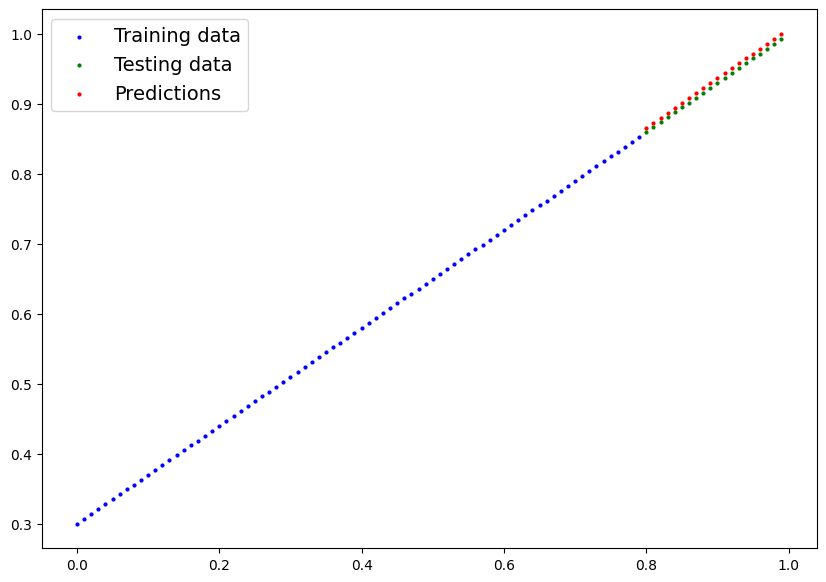

In [ ]:

                                            # making predictions with model and scattering on graph to visualize

model_2.eval()
with torch.inference_mode():
  y_preds_reg= model_2(x_test_reg)

plot_predictions(train_data=x_train_reg.cpu(),
                 train_labels= y_train_reg.cpu(),
                 test_data= x_test_reg.cpu(),
                 test_labels= y_test_reg.cpu(),
                 predictions=y_preds_reg.cpu())


                                                                  # IMPORTANT
# CONCLUSION: MODEL LEARNIG CAPABILITY IS GREAT AND MODEL ARCHTECTURE IS SOUND , FIX THE NON_LINERITY(model is learning only linear lines and not non_linearity)





# `2.`***REAL MODEL***   Building the Model with non-linearity


*   Linear = straight lines
*   Non-linear = non-straight lines



Artificial neural networks are a large combination of linear (straight) and non-straight (non-linear) functions which are potentially able to find patterns in data.

In [ ]:
import torch
from torch import nn
import matplotlib.pyplot as plt
from pathlib import Path

#Importing and Analyzing the Toy dataSet  

In [ ]:
                                                  # Importing and Analyzing the Toy dataSet

from sklearn.datasets import make_circles

X, y= make_circles(n_samples=1000, noise=0.03, random_state=42)

print(
      'Features:\n',    X[:5],              '\n\n',
      'labels:\n',      y[:5],              '\n\n',
      'shape:\n',       X.shape, y.shape,   '\n\n',
      'dataTypes:\n',   X.dtype, y.dtype,   '\n\n',
      'type:\n',        type(X), type(y)
      )

Features:
 [[ 0.75424625  0.23148074]
 [-0.75615888  0.15325888]
 [-0.81539193  0.17328203]
 [-0.39373073  0.69288277]
 [ 0.44220765 -0.89672343]] 

 labels:
 [1 1 1 1 0] 

 shape:
 (1000, 2) (1000,) 

 dataTypes:
 float64 int64 

 type:
 <class 'numpy.ndarray'> <class 'numpy.ndarray'>


In [ ]:
import pandas as pd
df= pd.DataFrame({
    'X1':X[:,0],
    'x2':X[:,1],
    'label':y
    })

print(df.head(5))

df['label'].value_counts()

         X1        x2  label
0  0.754246  0.231481      1
1 -0.756159  0.153259      1
2 -0.815392  0.173282      1
3 -0.393731  0.692883      1
4  0.442208 -0.896723      0


,count
label,
1,500
0,500


Text(0, 0.5, 'X2: (2st colums)')

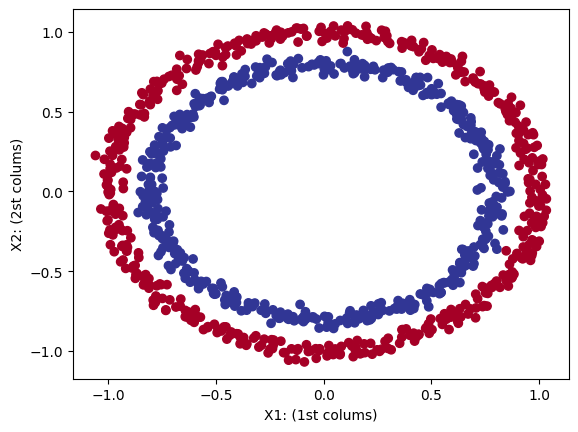

In [ ]:
# plotting the data to visualze it

plt.scatter(X[:,0], X[:,1], c=y, cmap=plt.cm.RdYlBu)
plt.xlabel('X1: (1st colums)')
plt.ylabel('X2: (2st colums)')

In [ ]:
# data is in numpy format and dtype isn't float32 , convert it for test_train_split

X=torch.from_numpy(X).type(torch.float32)
y= torch.from_numpy(y).type(torch.float32)
X.dtype, y.dtype ,type(X), type(y)


(torch.float32, torch.float32, torch.Tensor, torch.Tensor)

#Splitting the data for test_train_split

In [ ]:
from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test= train_test_split(X, y, test_size=0.2, random_state=42)

len(x_train), len(y_train), len(x_test), len(y_test)

(800, 800, 200, 200)

#Building the model with `relu()` non_linearity

In [ ]:
# finalized model with complete improvements

# device agnostic code
device= 'cuda' if torch.cuda.is_available() else 'cpu'

class CircleModelV2(nn.Module):
  def __init__(self):
    super().__init__()

    self.layer1= nn.Linear(in_features=2, out_features=10)
    self.layer2= nn.Linear(in_features=10, out_features=10)
    self.relu= nn.ReLU()
    self.layer3= nn.Linear(in_features=10, out_features=1)

  def forward(self, x:torch.Tensor) ->torch.Tensor:
    return self.layer3(self.relu(self.layer2(self.relu(self.layer1(x)))))

    """         OR
    z=self.layer1(x)
    z=self.relu(z)
    z=self.layer2(z)
    z=self.relu(z)
    z= self.layer3(z)

                      """
model_3= CircleModelV2().to(device)

model_3, next(model_3.parameters()).device

(CircleModelV2(
   (layer1): Linear(in_features=2, out_features=10, bias=True)
   (layer2): Linear(in_features=10, out_features=10, bias=True)
   (relu): ReLU()
   (layer3): Linear(in_features=10, out_features=1, bias=True)
 ),
 device(type='cuda', index=0))

##loss function / accuracy function & optimizer

In [ ]:
# loss function / accuracy function and optimizer

loss_fn= nn.BCEWithLogitsLoss()

optimizer= torch.optim.Adam(params=model_3.parameters(),
                            lr=0.1)


def accuracy_fn(y_true, y_pred):
  correct= torch.eq(y_true, y_pred).sum().item()
  accuracy= (correct / len(y_pred) ) * 100
  return accuracy

# Trainig the Model and Evaluating Model

In [ ]:
# Trainig the Model and Evaluating it

torch.manual_seed(42)
torch.cuda.manual_seed(42)

x_train, y_train = x_train.to(device), y_train.to(device)
x_test, y_test   = x_test.to(device),  y_test.to(device)

epochs=1000

for epoch in range(epochs):
  model_3.train()

  # forward pass
  train_logits= model_3(x_train).squeeze()                            # preds are in raw logits format

  train_preds= torch.round(torch.sigmoid(train_logits))              # raw logits --> pred_probs --> predictions

  # calculate the loss
  train_loss= loss_fn(train_logits, y_train)

  train_accu= accuracy_fn(y_true= y_train, y_pred= train_preds)

  # zero_grad()
  optimizer.zero_grad()

  # back propagation
  train_loss.backward()

  # gradient descent
  optimizer.step()

                                                # Now Evaluating/testing Model

  model_3.eval()

  with torch.inference_mode():
    # forward_pass
    test_logits= model_3(x_test).squeeze()

    test_preds= torch.round(torch.sigmoid(test_logits))

    # calcualte loss
    test_loss=loss_fn(test_logits, y_test)

    test_accu= accuracy_fn(y_true= y_test, y_pred= test_preds)

    # printing results

    if epoch % 50 ==0:
      print(f"epoch:{epoch}, training_loss:{train_loss:.4f}, training_accuracy:{train_accu:.2f}%, testing_loss:{test_loss:.4f}, testing_accuracy:{test_accu:.2f}%")

epoch:0, training_loss:0.6960, training_accuracy:50.00%, testing_loss:0.6909, testing_accuracy:50.00%
epoch:50, training_loss:0.0033, training_accuracy:100.00%, testing_loss:0.0141, testing_accuracy:100.00%
epoch:100, training_loss:0.0014, training_accuracy:100.00%, testing_loss:0.0067, testing_accuracy:100.00%
epoch:150, training_loss:0.0009, training_accuracy:100.00%, testing_loss:0.0048, testing_accuracy:100.00%
epoch:200, training_loss:0.0006, training_accuracy:100.00%, testing_loss:0.0035, testing_accuracy:100.00%
epoch:250, training_loss:0.0005, training_accuracy:100.00%, testing_loss:0.0029, testing_accuracy:100.00%
epoch:300, training_loss:0.0004, training_accuracy:100.00%, testing_loss:0.0026, testing_accuracy:100.00%
epoch:350, training_loss:0.0003, training_accuracy:100.00%, testing_loss:0.0023, testing_accuracy:100.00%
epoch:400, training_loss:0.0002, training_accuracy:100.00%, testing_loss:0.0021, testing_accuracy:100.00%
epoch:450, training_loss:0.0002, training_accuracy:

#Making prediction from trained and tested Model



In [ ]:
# Makes predictions
model_3.eval()

with torch.inference_mode():
  y_preds = torch.round(torch.sigmoid(model_3(x_test))).squeeze()
y_preds[:10], y_test[:10]



(tensor([1., 0., 1., 0., 1., 1., 0., 0., 1., 0.], device='cuda:0'),
 tensor([1., 0., 1., 0., 1., 1., 0., 0., 1., 0.], device='cuda:0'))

#Visualizng it with helper function

In [ ]:
import requests
from pathlib import Path

if Path('helper_function2.py').is_file():
  print('file already exists,skipping the download...')
else:
  request= requests.get('https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/helper_functions.py')

  with open('helper_function2.py', 'wb') as f:
    f.write(request.content)

from helper_function2 import plot_predictions, plot_decision_boundary

file already exists,skipping the download...


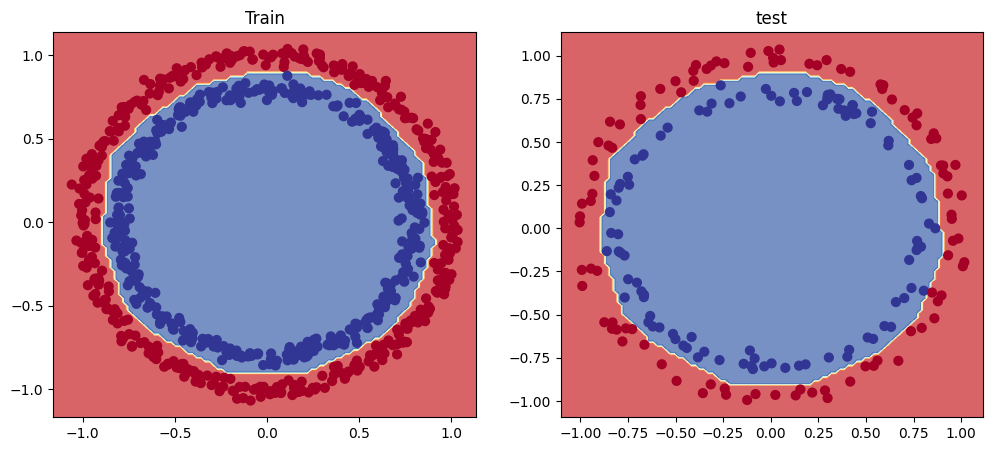

In [ ]:
plt.figure(figsize=(12,5))

plt.subplot(1,2,1)
plt.title('Train')
plot_decision_boundary(model_3, x_train, y_train)

plt.subplot(1,2,2)
plt.title('test')
plot_decision_boundary(model_3, x_test, y_test)

#                       IMPORTANT

                                            # MODEL IS SUCCESSFUL, ACCURACY IS 100
